# Ensemble Monte Carlo fitting of LG Beams

### Erik Flom, The University of Oklahoma

##### A Work in Progress: More functionality to be added soon!

## Generic Imports / Definitions

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import scipy
import pylab
import pandas as pd
import pylab
import emcee
import scipy.special
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10,10)
plt.style.use('seaborn-white')
matplotlib.rcParams.update({'font.size': 20,
                           'font.fantasy':'Helvetica'})

## Import Data

### Data are put into a single 3-D array of index:

### [NumberOfDataPoints, Y_Resolution, X_Resolution]

In [2]:
NumberOfPoints=25

LocationOnDisk="C:/Users/EFlom/Documents/Data/1-0/July_14/"
data = np.zeros([NumberOfPoints,1024,1024]) 
data_err = np.zeros([NumberOfPoints,1024,1024]) 
## 1039x1392 is the pixel size of our CCD Camera

for i in range(NumberOfPoints):
    data_string = LocationOnDisk + str(2*i+1) + "_" + "%04d" % (1) + ".asc"
    data[i,:,:] = pd.read_table(data_string, skiprows=7, nrows=1024, usecols = range(188,1212))
    data_err[i,:,:] = np.sqrt(data[i,:,:])
  
X, Y = np.meshgrid(np.arange(1,1025,1), np.arange(1,1025,1))


print("Done!")

Done!


## Generate 2D histograms of the Data (eye test)

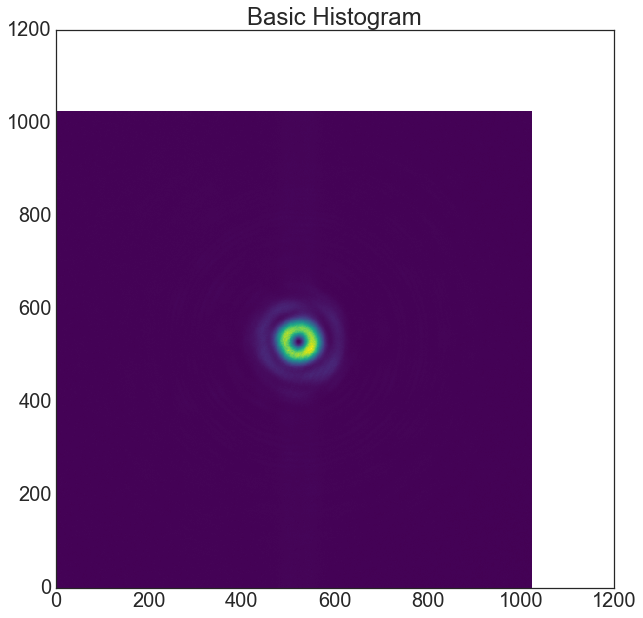

In [3]:
pylab.rcParams['figure.figsize'] = (10,10)
plt.pcolormesh(data[3,:,:], cmap='viridis')

plt.title('Basic Histogram')
plt.show()

### Plot Cross-Section of Data (eye test)

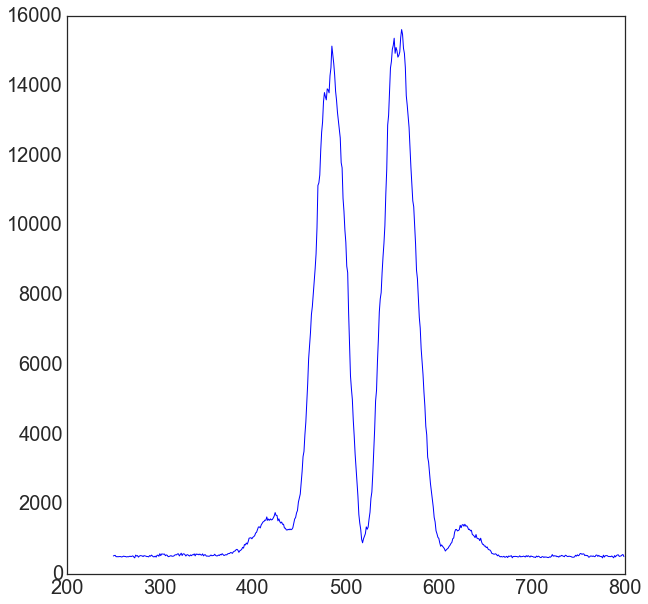

In [4]:
#This plots a cross-section at a specified y pixel row across the range of [xmin, xmax]

xmin = 250
xmax = 800
y_val = 500

cross_section = data[4, y_val, xmin:xmax]
x = np.arange(xmin, xmax, 1)
plt.plot(x, cross_section)


In [1023]:
binfactor=16

#  Monte Carlo Routine

## Definition of Various Beam Modes and Initial Value Guesses

In [1024]:
def Mode_1_0(params, binfactor = binfactor):
       
    X, Y = np.meshgrid(np.arange(1,1025,binfactor), np.arange(1,1025,binfactor))    
    A=((params[0]**2)*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**1
    B=1.
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  

def Mode_1_1(params, binfactor = binfactor):
       
    X, Y = np.meshgrid(np.arange(1,1025,binfactor), np.arange(1,1025,binfactor))    
    A=((params[0]**2)*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**1
    B=((2. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C)

def Mode_1_1_1(params, binfactor = binfactor):
       
    X, Y = np.meshgrid(np.arange(1,1025,binfactor), np.arange(1,1025,binfactor))    
    A=((params[0]**2)*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**1
    B = scipy.special.eval_genlaguerre(1, 1, 2*((X - params[3])**2 + (Y - params[4])**2)/params[1]**2)**2
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  

def Mode_1_2(params, binfactor = binfactor):
       
    X, Y = np.meshgrid(np.arange(1,1025,binfactor), np.arange(1,1025,binfactor))    
    A=((params[0]**2)*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**1
    B=((3.*(params[1]**4) - 6.*(params[1]**2)*(X - params[3])**2 - 6*(params[1])**2*(Y - params[4])**2 + 2*(X - params[3])**4 + 4*((X - params[3])**2)*((Y - params[4])**2) + 2*(Y - params[4])**4)/params[1]**4)**2
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  

    
def Mode_2_1(params, binfactor = binfactor):
    X, Y = np.meshgrid(np.arange(1,1025,binfactor), np.arange(1,1025,binfactor))
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**2
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  
    
def Mode_10_1(params):
    
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**10
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  
    
def Mode_5_0(params):
    
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**5
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  

def Mode_5_1(params):
    
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**5
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  


In [1025]:
Mode_1_1([fitted_params[5], fitted_params[6], fitted_params[2],fitted_params[3],fitted_params[4]],1) #+ Mode_1_0(fitted_params[5:], 1)


plt.title('Fit')
plt.xlabel('Position (arb. units)')
plt.ylabel('Position (arb. units)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.pcolormesh(fitted_curve, cmap='GnBu_r')
plt.colorbar()
plt.xlim(300,700)
plt.ylim(350,700)

ValueError: operands could not be broadcast together with shapes (1024,1024) (5,) 

## Instantiation of Walkers, addition of small random initial perturbation around guesses

## Definition of Prior, Likelihood, and Posterior 

In [1026]:
def log_prior(param):
    scale_min = 100.0
    scale_max = 4000.0
    width_min = 10.0
    width_max = 250.0
    baseline_min = 100.0
    baseline_max = 1200.0
    x0_min = 450.0
    x0_max = 650.0
    y0_min = 450.0
    y0_max = 650.0
        
    if ((scale_min <= param[0] <= scale_max) and
    (width_min <= param[1] <= width_max) and
    (baseline_min <= param[2] <= baseline_max)and 
    (x0_min <= param[3] <= x0_max)and 
    (y0_min <= param[4] <= y0_max)): 

        return 0.0
    
    else:
        return -np.inf
    
def log_prior1(param):
    scale_min = 30.0
    scale_max = 4000.0
    width_min = 20.0
    width_max = 350.0
    baseline_min = 100.0
    baseline_max = 1200.0
    x0_min = 350.0
    x0_max = 750.0
    y0_min = 350.0
    y0_max = 750.0
        
    if ((scale_min <= param[0] <= scale_max) and
    (width_min <= param[1] <= width_max) and
    (baseline_min <= param[2] <= baseline_max)and 
    (x0_min <= param[3] <= x0_max)and 
    (y0_min <= param[4] <= y0_max)): 

        return 0.0
    
    else:
        return -np.inf
    
def log_prior2(param):
    scale_min = 100.0
    scale_max = 4000.0
    width_min = 40.0
    width_max = 250.0
    baseline_min = -50.0
    baseline_max = 1200.0
    x0_min = 450.0
    x0_max = 650.0
    y0_min = 450.0
    y0_max = 650.0
        
    if ((scale_min <= param[0] <= scale_max) and
    (width_min <= param[1] <= width_max) and
    (baseline_min <= param[2] <= baseline_max)and 
    (x0_min <= param[3] <= x0_max)and 
    (y0_min <= param[4] <= y0_max)): 

        return 0.0
    
    else:
        return -np.inf
 





def log_likelihood(param, z, data_err):
   
    model = Mode_1_0(param[:5])
    likelihood = (-0.5)*(np.sum(np.sum(((model - z)/data_err)**2))) - np.log(np.size(z))
    return likelihood

def log_likelihood1(param, z, data_err):
   
    model = Mode_1_0(param[:5])
    likelihood = (-0.5)*(np.sum(np.sum(((model - z)/data_err)**2))) - np.log(np.size(z))
    return likelihood

def log_likelihood2(param, z, data_err):
   
    model = Mode_1_0(param[:5])
    likelihood = (-0.5)*(np.sum(np.sum(((model - z)/data_err)**2))) - np.log(np.size(z))
    return likelihood





def log_posterior(param, z, data_err):
    return (log_prior(param) + log_likelihood(param, z, data_err))/(np.size(z) - 5)

def log_posterior1(param, z, data_err):
    return (log_prior1(param) + log_likelihood1(param, z, data_err))/(np.size(z) - 5)

def log_posterior2(param, z, data_err):
    return (log_prior2(param) + log_likelihood2(param, z, data_err))/(np.size(z) - 5)

## Definition of Binning Function (note: binfactor must be power of 2)

In [1004]:

X, Y = np.meshgrid(np.arange(1,1024 +1 ,binfactor), np.arange(1,1024 + 1,binfactor))
params = [300,25,600,550,550]

nwalkers = 50
z = Mode_1_0(params[:5])


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

## Definition of Main() Function -- This is what actually implements the MCMC. It is called in the next cell.

In [1013]:
def Main(data_to_fit, errors_to_fit, guesses, numsims=500, burnin=250, nwalkers=100):

    ndim = 5
    
    nwalkers = 50
    
    scale_i1 = guesses[0]+100.0*np.random.randn(nwalkers)
    width_i1 = guesses[1]+5.0*np.random.randn(nwalkers)
    baseline_i1 = guesses[2]+30.0*np.random.randn(nwalkers)
    x0_i1 = guesses[3]+10.0*np.random.randn(nwalkers)
    y0_i1 = guesses[4]+10.0*np.random.randn(nwalkers)
    

    pos = [scale_i1]+[width_i1]+[baseline_i1]+[x0_i1]+[y0_i1]
    posNew=(np.array(pos)).T

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior1, args=[data_to_fit, errors_to_fit])
    %time sampler.run_mcmc(posNew, numsims) # %time is used to time this line of the function. It will print the CPU time in the output
    
    chain=sampler.chain
    lnprob=sampler.lnprobability
    acceptance=sampler.acceptance_fraction
    
    
    percent_regions=[1.0-0.9973,1.0-0.9545,1.0-0.6827,0.5,0.6827,0.9545,0.9973]

    confidence_regions_params=np.zeros([7,ndim])

    acceptances = [np.percentile(acceptance, 5), np.percentile(acceptance, 50), np.percentile(acceptance, 95)]
    scale = [np.percentile(chain[:,burnin:numsims,0], 5), np.percentile(chain[:,burnin:numsims,0], 50), np.percentile(chain[:,burnin:numsims,0], 95)]
    width =  [np.percentile(chain[:,burnin:numsims,1], 5), np.percentile(chain[:,burnin:numsims,1], 50), np.percentile(chain[:,burnin:numsims,1], 95)]
    background =  [np.percentile(chain[:,burnin:numsims,2], 5), np.percentile(chain[:,burnin:numsims,2], 50), np.percentile(chain[:,burnin:numsims,2], 95)]
    x0 =  [np.percentile(chain[:,burnin:numsims,3], 5), np.percentile(chain[:,burnin:numsims,3], 50), np.percentile(chain[:,burnin:numsims,3], 95)]
    y0 =  [np.percentile(chain[:,burnin:numsims,4], 5), np.percentile(chain[:,burnin:numsims,4], 50), np.percentile(chain[:,burnin:numsims,4], 95)]
    logPDF = [np.percentile(lnprob[:, burnin:numsims], 5), np.percentile(lnprob[:, burnin:numsims], 50), np.percentile(lnprob[:, burnin:numsims], 95)]
    
    
    return acceptances, scale, width, background, x0, y0, logPDF, chain, lnprob, acceptance, sampler.flatchain
    

## Calling the Main() within a For loop to analyze entire data series. Input initial guesses here.

In [1033]:
ndim = 5
numsims = 250
nwalkers=50
burnin=100
binfactor=16
X, Y = np.meshgrid(np.arange(1,1024 +1 ,binfactor), np.arange(1,1024 + 1,binfactor))

guesses = [300,25,600,550,550] #guesses ONLY for first run. Everything else done recursively.


scale_i1 = params[0]+45.0*np.random.randn(nwalkers)
width_i1 = params[1]+3.0*np.random.randn(nwalkers)
baseline_i1 = params[2]+30.0*np.random.randn(nwalkers)
x0_i1 = params[3]+10.0*np.random.randn(nwalkers)
y0_i1 = params[4]+10.0*np.random.randn(nwalkers)


acceptances = np.zeros((NumberOfPoints,3))
scales = np.zeros((NumberOfPoints,3))
widths = np.zeros((NumberOfPoints,3))
backgrounds = np.zeros((NumberOfPoints,3))
x0s = np.zeros((NumberOfPoints,3))
y0s = np.zeros((NumberOfPoints,3))
logPDFs = np.zeros((NumberOfPoints,3))
chain = np.zeros((NumberOfPoints, nwalkers, numsims, ndim))
lnprob = np.zeros((NumberOfPoints, nwalkers, numsims))
acceptance = np.zeros((NumberOfPoints, nwalkers))
flatchain = np.zeros((NumberOfPoints, nwalkers*numsims, ndim))


for i in range(NumberOfPoints):
    
    data_new = rebin(data[i,:,:], (1024/binfactor,1024/binfactor))
    err_new = rebin(data_err[i,:,:], (1024/binfactor,1024/binfactor))
    
    acceptances[i,:], scales[i,:], widths[i,:], backgrounds[i,:], x0s[i,:], y0s[i,:], logPDFs[i,:], chain[i,:,:,:], lnprob[i,:,:], acceptance[i,:], flatchain[i,:,:] = Main(data_new, err_new, guesses, numsims, burnin, nwalkers)
    
    guesses[1] = guesses[1] + 12
    
    if i%5 == 0: print i
    

Wall time: 6.98 s
0
Wall time: 6.24 s
Wall time: 6.24 s
Wall time: 6.64 s
Wall time: 5.7 s
Wall time: 5.21 s
5
Wall time: 5.86 s
Wall time: 7.56 s
Wall time: 6 s
Wall time: 5.45 s
Wall time: 5.64 s
10
Wall time: 6.38 s
Wall time: 6.08 s
Wall time: 6.38 s
Wall time: 5.9 s
Wall time: 4.01 s
15
Wall time: 4.46 s
Wall time: 4.04 s
Wall time: 4.26 s
Wall time: 6.17 s
Wall time: 6.72 s
20
Wall time: 6.55 s
Wall time: 4.55 s
Wall time: 3.58 s
Wall time: 4.18 s


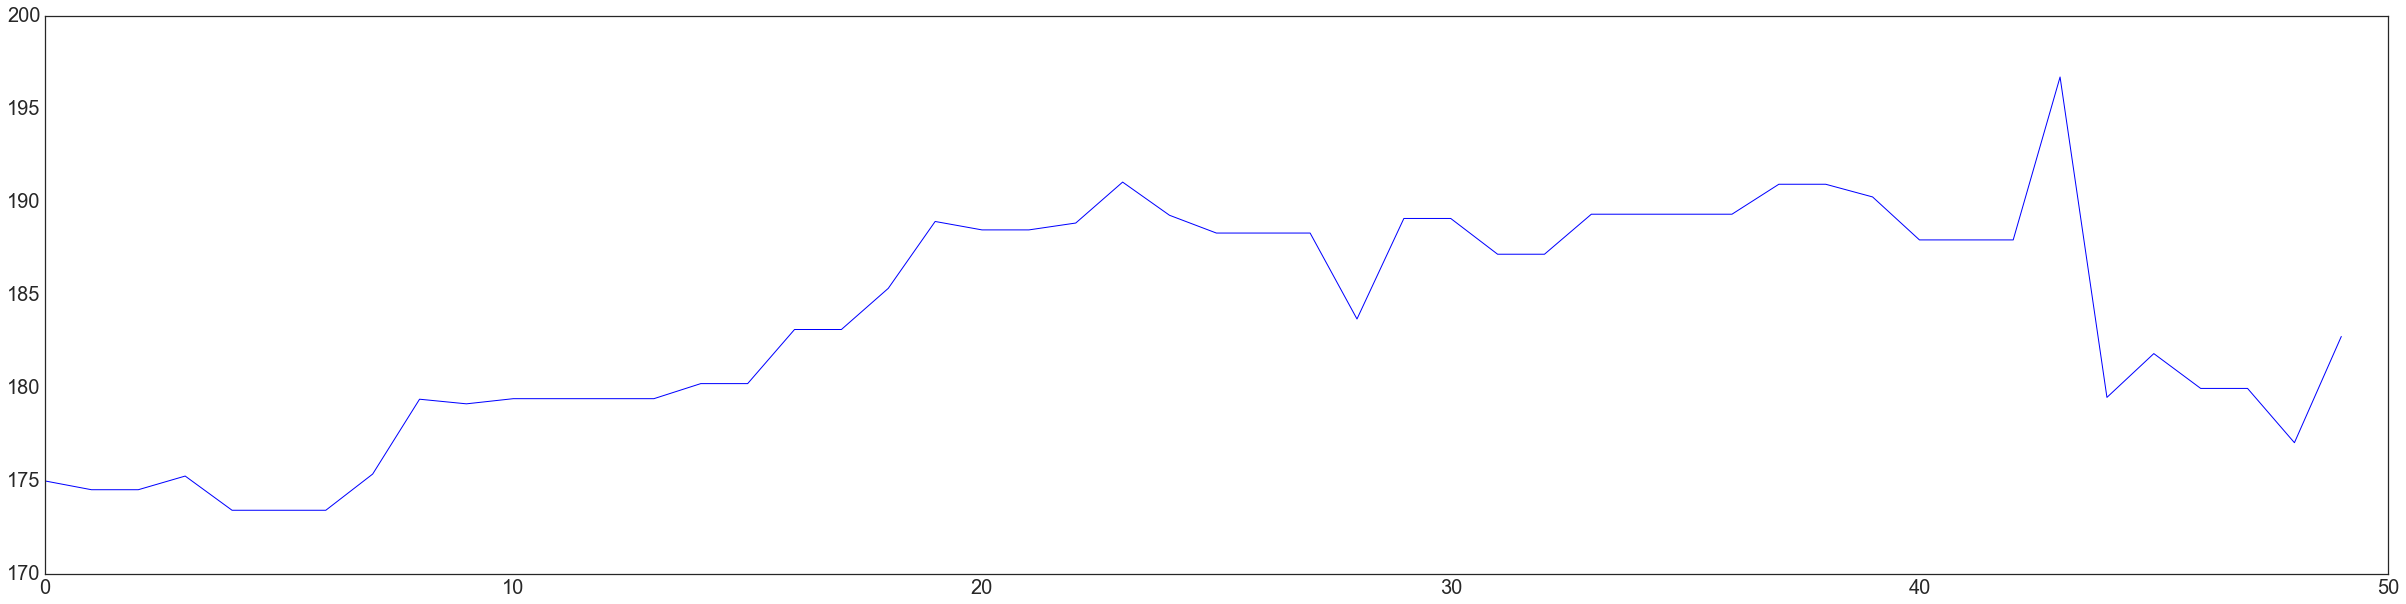

In [666]:
plt.plot(chain[5,5,200:,0])

<type 'numpy.ndarray'>


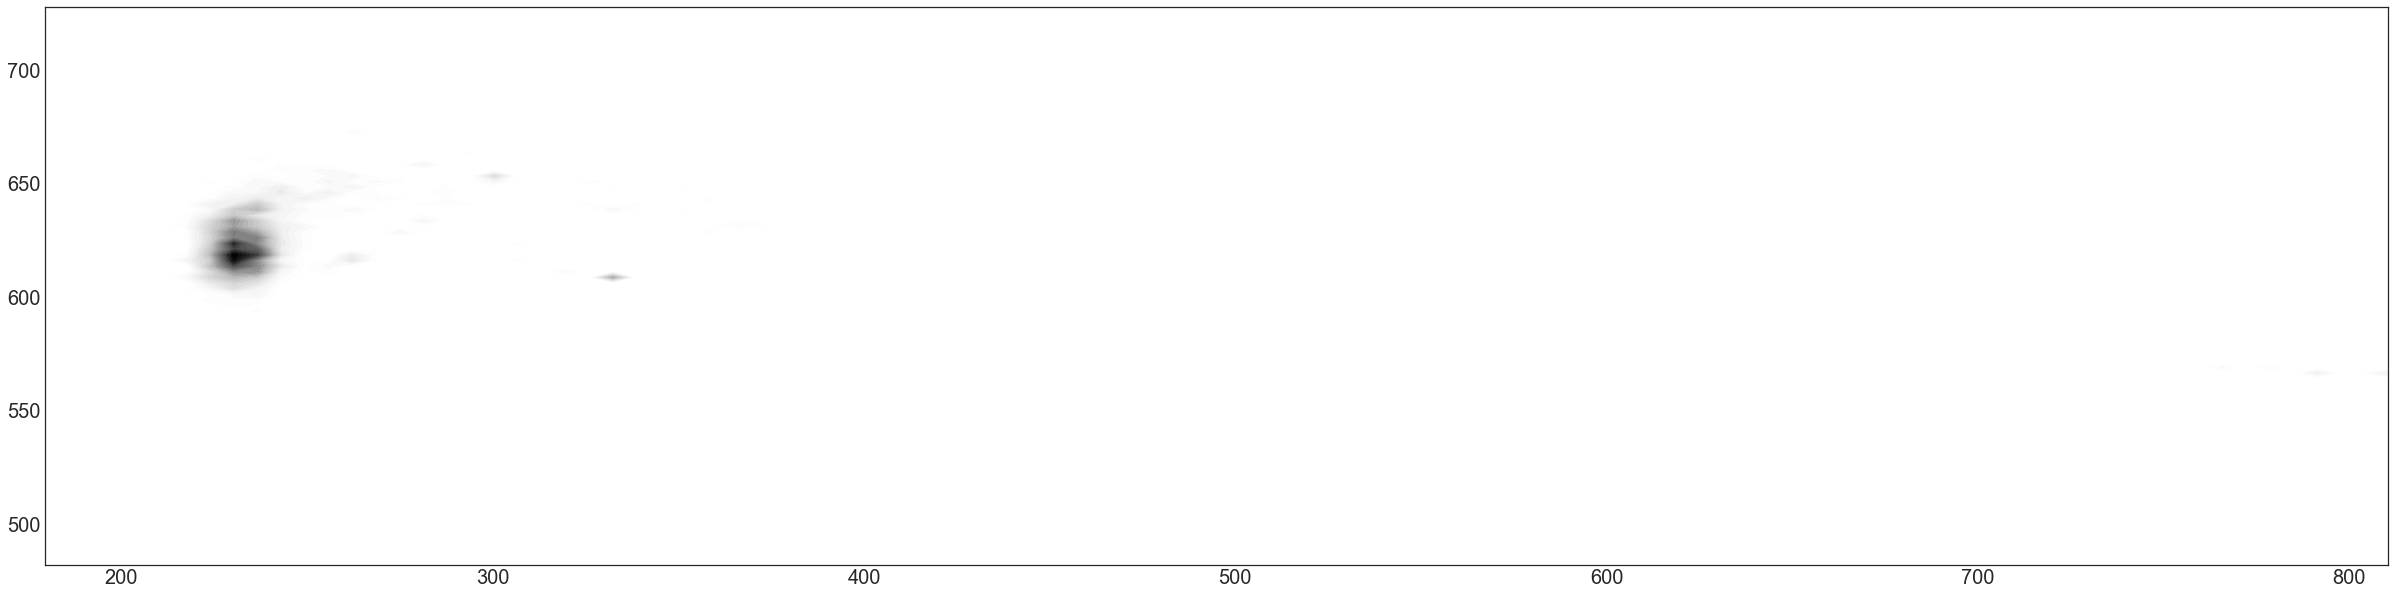

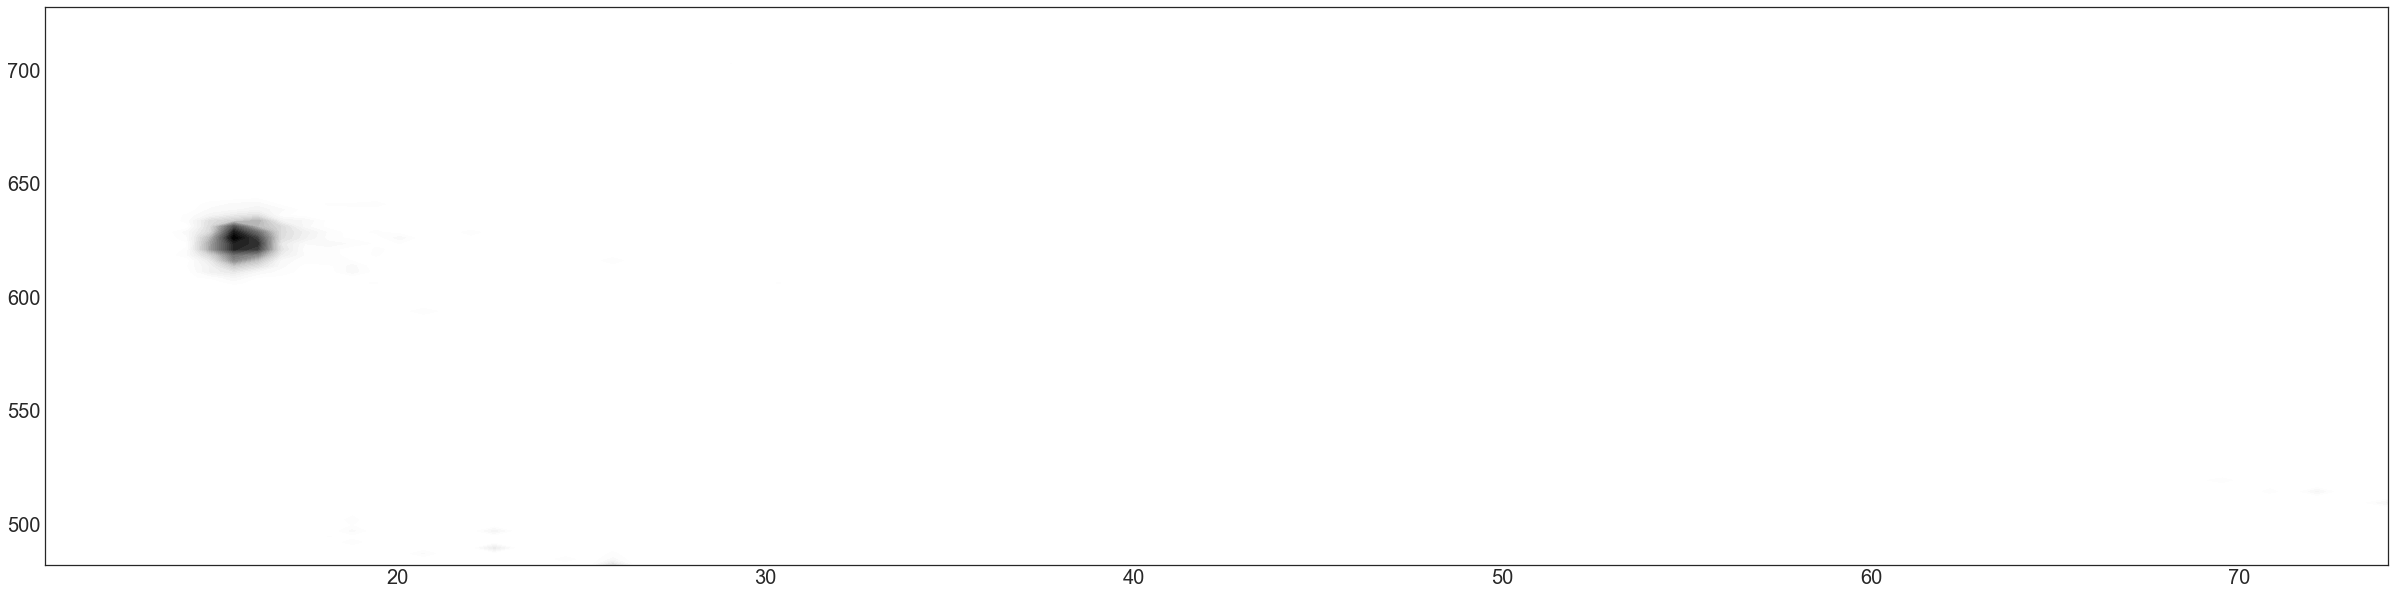

In [667]:
def PlotDensity(density, pos1out, pos2out):
    delta=density.max()/30.0
    levels=delta+delta*np.arange(30)
    plt.contourf(pos1out,pos2out,density,levels)

def MakeContour(samples, index1, index2, numbins):
     numout=len(samples)
     comp1=samples[0:numout,index1]
     comp2=samples[0:numout,index2]
     binsize1=(comp1.max()-comp1.min())/numbins
     binsize2=(comp2.max()-comp2.min())/numbins
     density=np.zeros([numbins,numbins])
     pos1=(comp1-comp1.min())/binsize1
     pos2=(comp2-comp2.min())/binsize2
     pos1out=comp1.min()+0.5*binsize1+binsize1*np.arange(numbins)
     pos2out=comp2.min()+0.5*binsize2+binsize2*np.arange(numbins)
     for i in range(numout):
        if (long(pos1[i])) < numbins and (long(pos2[i])) < numbins:
            density[long(pos1[i]),long(pos2[i])]=density[long(pos1[i]),long(pos2[i])]+1.0
     return density, pos1out, pos2out

index1=2
index2=3
numbins=100
density, pos1out, pos2out=MakeContour(flatchain[4],index1,index2,numbins)
print type(flatchain)
PlotDensity(density,pos1out,pos2out)
plt.show()

index1=1
index2=3
numbins=100
density, pos1out, pos2out=MakeContour(flatchain[4],index1,index2,numbins)
plt.show()

PlotDensity(density,pos1out,pos2out)
PlotDensity(density, pos1out, pos2out)

(25L, 50L, 100L, 5L)
(625000L,)


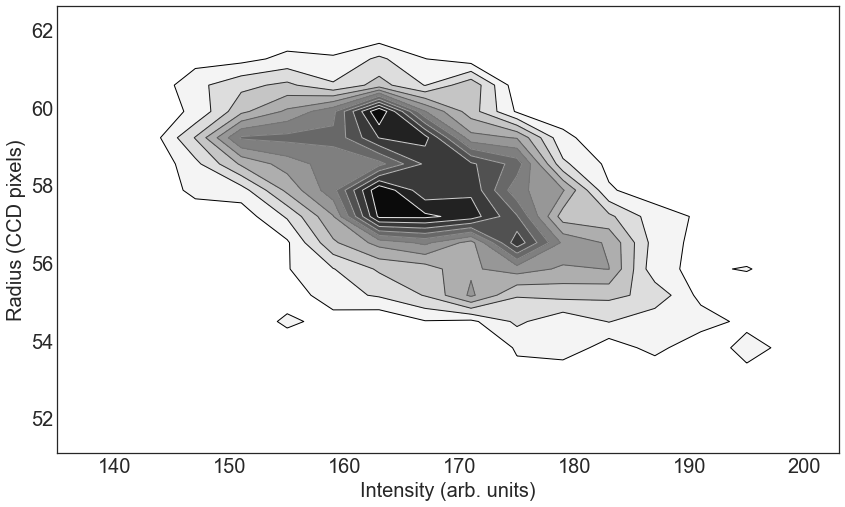

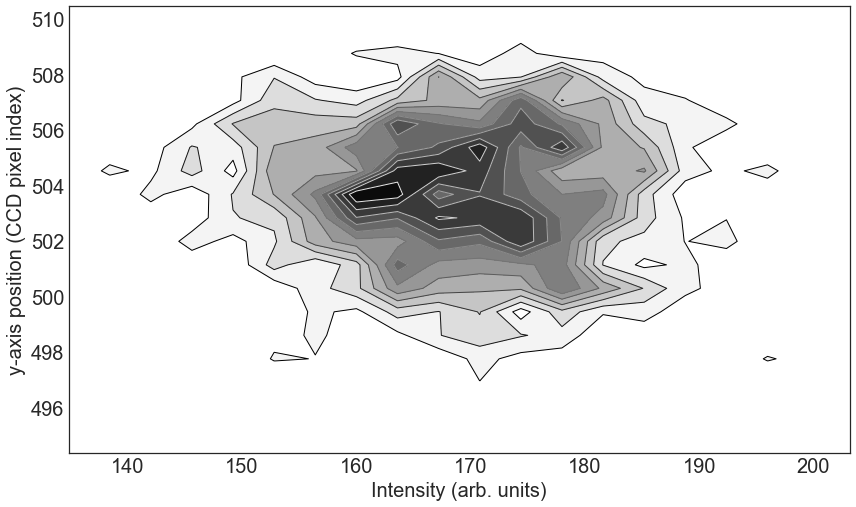

In [949]:
def PlotDensity1(density, pos1out, pos2out):
    delta=density.max()/12.0
    levels=delta+delta*np.arange(12)
    plt.contour(pos1out,pos2out,density,levels, cmap = 'gray')
    
def PlotDensity2(density, pos1out, pos2out):
    delta=density.max()/12.0
    levels=delta+delta*np.arange(12)
    plt.contourf(pos1out,pos2out,density,levels, cmap = 'gray_r')

def MakeContour(samples, index1, index2, numbins):
     numout=len(samples)
     comp1=samples[0:numout,index1]
     comp2=samples[0:numout,index2]
     binsize1=(comp1.max()-comp1.min())/numbins
     binsize2=(comp2.max()-comp2.min())/numbins
     density=np.zeros([numbins,numbins])
     pos1=(comp1-comp1.min())/binsize1
     pos2=(comp2-comp2.min())/binsize2
     pos1out=comp1.min()+0.5*binsize1+binsize1*np.arange(numbins)
     pos2out=comp2.min()+0.5*binsize2+binsize2*np.arange(numbins)
     for i in range(numout):
        if (long(pos1[i])) < numbins and (long(pos2[i])) < numbins:
            density[long(pos1[i]),long(pos2[i])]=density[long(pos1[i]),long(pos2[i])]+1.0
     return density, pos1out, pos2out

pylab.rcParams['figure.figsize'] = (14,8)
index1=0
index2=1
numbins=18

burnin=150
array1 = np.zeros((NumberOfPoints, nwalkers, numsims - burnin, ndim))

for i in range(nwalkers):
    array = chain[5,i,burnin:,:]
    array1[:,i,:,:] = array



print np.shape(array1)
array1 = np.ravel(array1)
print np.shape(array1)
array1 = np.reshape(array1, (25, nwalkers*(numsims - burnin), 5))

density, pos1out, pos2out=MakeContour(array1[14,:,:],index1,index2,numbins)
PlotDensity1(density,pos1out,pos2out)
PlotDensity2(density,pos1out,pos2out)
#plt.xlim((170,210))
#plt.ylim((35,65))
plt.xlabel('Intensity (arb. units)')
plt.ylabel('Radius (CCD pixels)')
plt.show()

index1=0
index2=4
numbins=20

    
density, pos1out, pos2out=MakeContour(array1[14,:,:],index1,index2,numbins)
PlotDensity2(density,pos1out,pos2out)
PlotDensity1(density,pos1out,pos2out)

#plt.xlim((520,540))
#plt.ylim((500,530))
plt.xlabel('Intensity (arb. units)')
plt.ylabel('y-axis position (CCD pixel index)')
plt.show()

In [ ]:
plt.plot

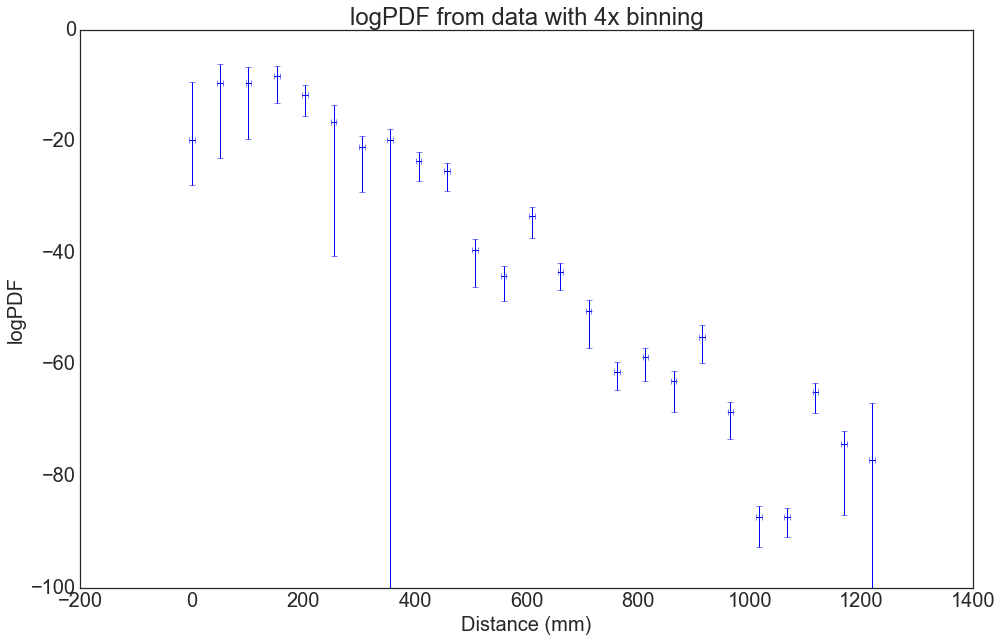

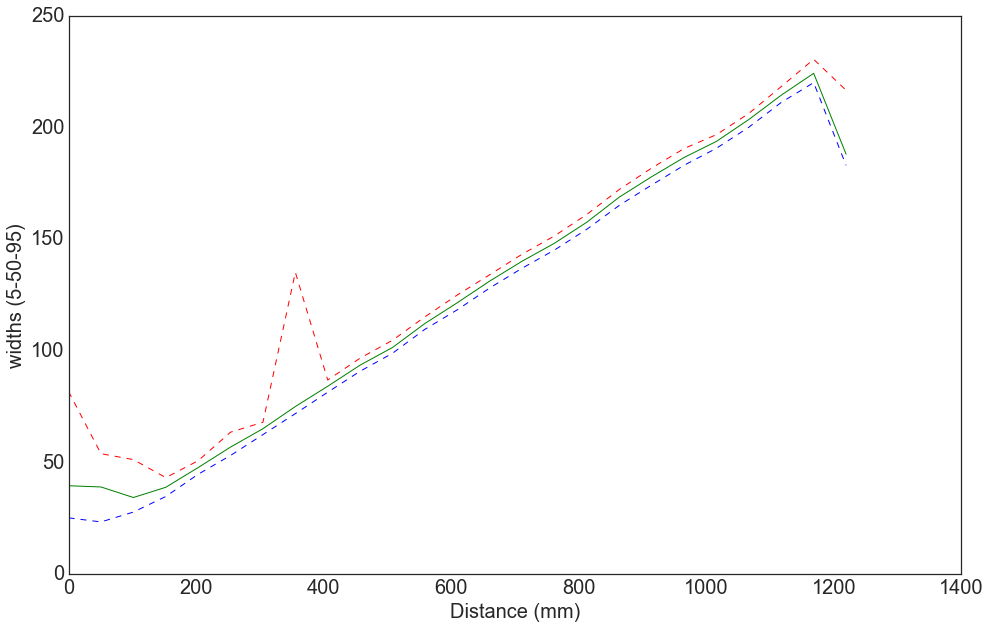

In [1016]:
pylab.rcParams['figure.figsize'] = (16,10)
PDF_err = logPDFs[:,2] - logPDFs[:,0]

plt.errorbar(np.arange(25)*50.8,logPDFs[:,1], yerr=[logPDFs[:,1] - logPDFs[:,0], logPDFs[:,2] - logPDFs[:,1]], xerr=5, fmt = '+')

plt.xlabel('Distance (mm)')
plt.ylabel('logPDF')
plt.title('logPDF from data with 4x binning')
plt.ylim((-100, 0))
plt.show()

pylab.rcParams['figure.figsize'] = (16,10)
plt.plot(np.arange(25)*50.8,widths[:,0], ls="--")
plt.plot(np.arange(25)*50.8,widths[:,1], lw = 1)
plt.plot(np.arange(25)*50.8,widths[:,2], ls='--')
plt.xlabel('Distance (mm)')
plt.ylabel('widths (5-50-95)')

plt.show()

In [ ]:
widths

## Plot Histograms of Parameters

In [ ]:
z = Mode_1_0(params)
            
pylab.rcParams['figure.figsize'] = (10,10)            
plt.pcolormesh(data_new, cmap='viridis')

(25L, 50L)


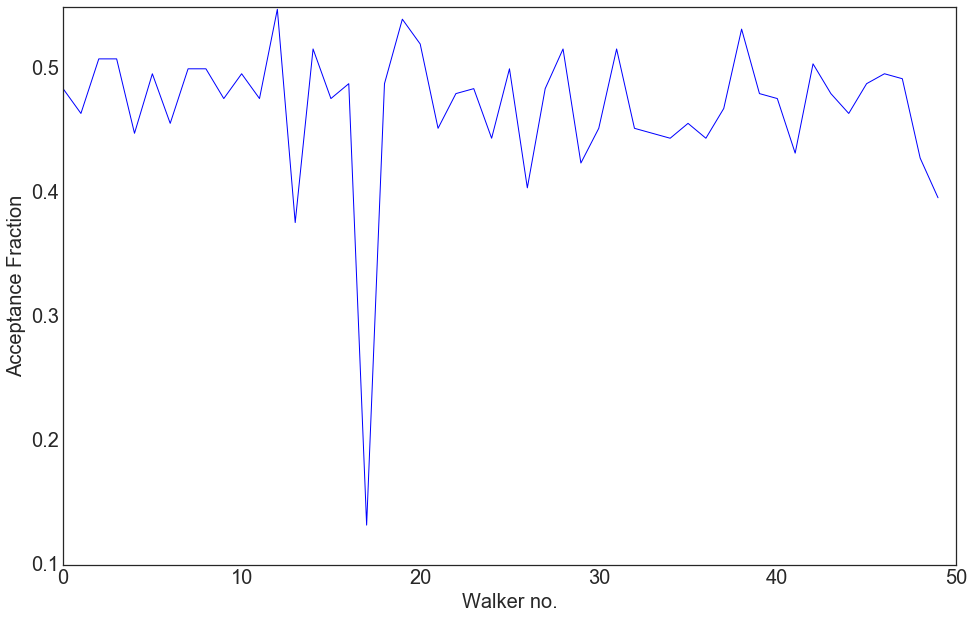

In [1017]:
print np.shape(acceptance)
plt.plot(acceptance[5])
plt.xlabel('Walker no.')
plt.ylabel('Acceptance Fraction')

In [939]:
print np.shape(chain)

(25L, 50L, 250L, 5L)


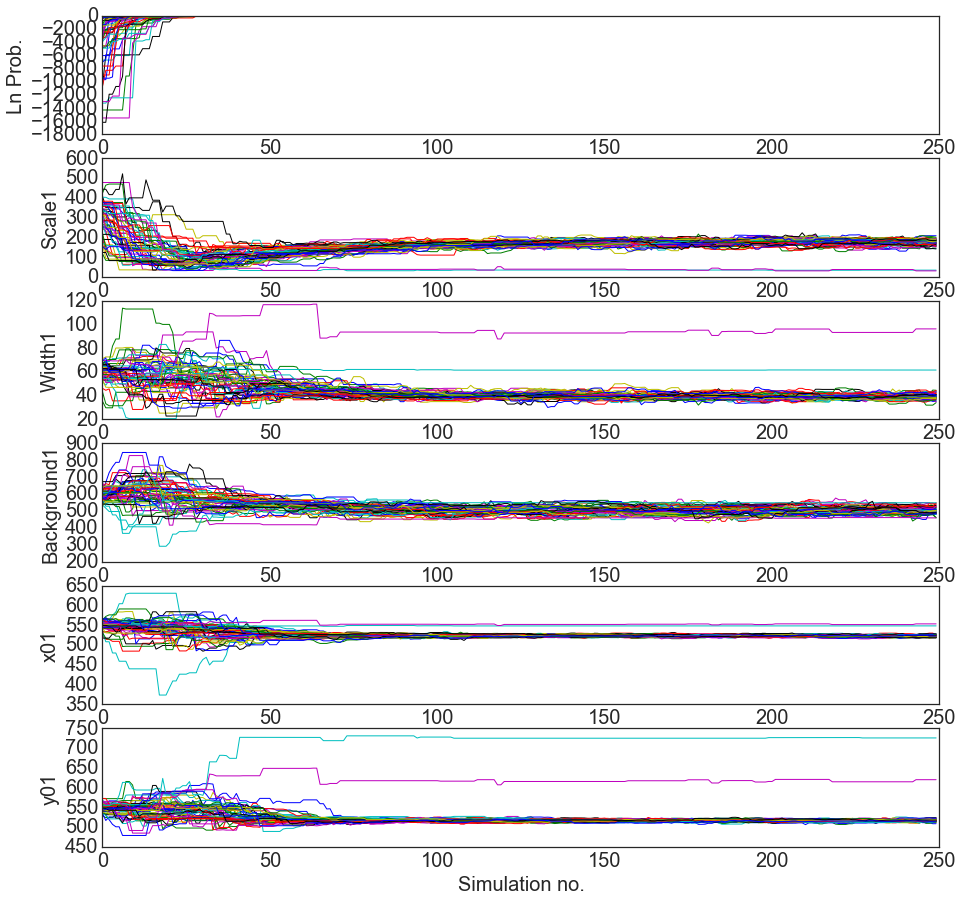

In [936]:
### Analyze walker movement for a specific trial number

trial_to_examine = 1
burnin_plot = 0

index = np.arange(numsims)
from matplotlib import pyplot
trial_to_examine = 3
pylab.rcParams['figure.figsize'] = (15,20)
for i in range(nwalkers):
    pyplot.subplot(8,1,1)
    plt.plot(index[burnin_plot:], lnprob[trial_to_examine,i, burnin_plot:numsims])
    plt.xlabel('simulation no.')
    plt.ylabel('Ln Prob.')
    
    pyplot.subplot(8,1,2)
    plt.plot(index[burnin_plot:], chain[trial_to_examine,i,burnin_plot:numsims,0])
    plt.xlabel('Simulation no.')
    plt.ylabel('Scale1')
    
    pyplot.subplot(8,1,3)
    plt.plot(index[burnin_plot:], chain[trial_to_examine,i,burnin_plot:numsims,1])
    plt.xlabel('Simulation no.')
    plt.ylabel('Width1')
    
    pyplot.subplot(8,1,4)
    plt.plot(index[burnin_plot:], chain[trial_to_examine,i,burnin_plot:numsims,2])
    plt.xlabel('Simulation no.')
    plt.ylabel('Background1')
    
    pyplot.subplot(8,1,5)
    plt.plot(index[burnin_plot:], chain[trial_to_examine,i,burnin_plot:numsims,3])
    plt.xlabel('Simulation no.')
    plt.ylabel('x01')
    
    pyplot.subplot(8,1,6)
    plt.plot(index[burnin_plot:], chain[trial_to_examine,i,burnin_plot:numsims,4])
    plt.xlabel('Simulation no.')
    plt.ylabel('y01')
    

    
plt.show()
    

In [ ]:
pylab.rcParams['figure.figsize'] = (20,0)
for i in range(nwalkers):

    plt.plot(index[burnin:], chain[trial_to_examine,i,burnin:numsims,0])
    plt.xlabel('Simulation no.')
    plt.ylabel('Scale1')

plt.show()


(25L, 50L, 250L, 5L)


ValueError: cannot reshape array of size 0 into shape (2500,250)

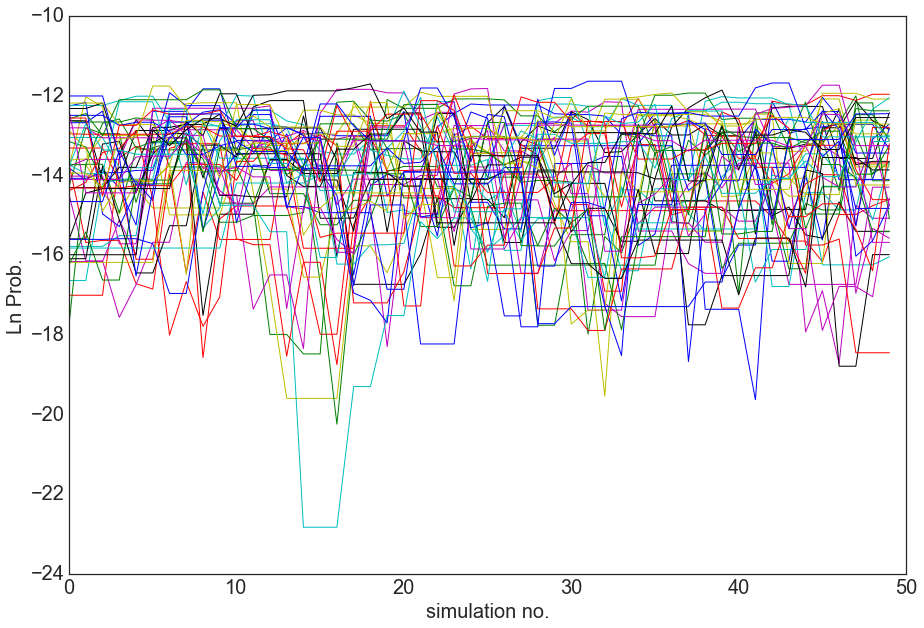

In [886]:
def MakeHistogram(trial_no, samples, burnin, index, numbins):
    samples = samples[trial_no,:,:,:]
    numout=len(samples)
    comp=samples[0:numout,burnin:,index]
    comp_histogram=np.array(np.histogram(comp,bins=numbins,range=[comp.min(),comp.max()]))
    comp_histogram_y=comp_histogram[0]
    temp=comp_histogram[1]
    binsize=temp[1]-temp[0]
    comp_histogram_x=comp.min()+0.5*binsize+binsize*np.arange(numbins)
    return comp_histogram_x,comp_histogram_y

print chain.shape
ndim=chain.shape[2]



for i in range(nwalkers):
    plt.plot(np.arange(numsims-burnin), lnprob[5,i, burnin:numsims])
    plt.xlabel('simulation no.')
    plt.ylabel('Ln Prob.')

lnprob2=lnprob[:,burnin:].reshape((-1))
temp=chain[:,burnin:,0:ndim]
sample=temp.reshape(((numsims-burnin)*nwalkers,ndim))

print lnprob2.shape
print sample.shape
print np.mean(lnprob[:, burnin:numsims])

## Make Histogram of Scaling Factor

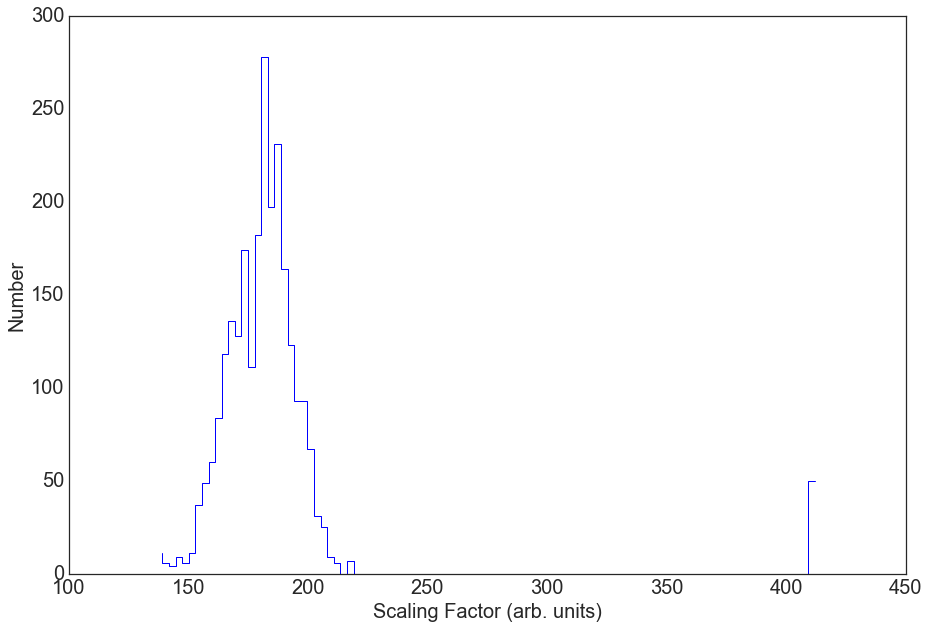

In [673]:
index=0
numbins = 100
pylab.rcParams['figure.figsize'] = (15,10)
comp_hist_0_x,comp_hist_0_y=MakeHistogram(trial_to_examine,chain,burnin,index,numbins)
plt.xlabel('Scaling Factor (arb. units)')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps', fillstyle='bottom')

## Make Histogram of Width

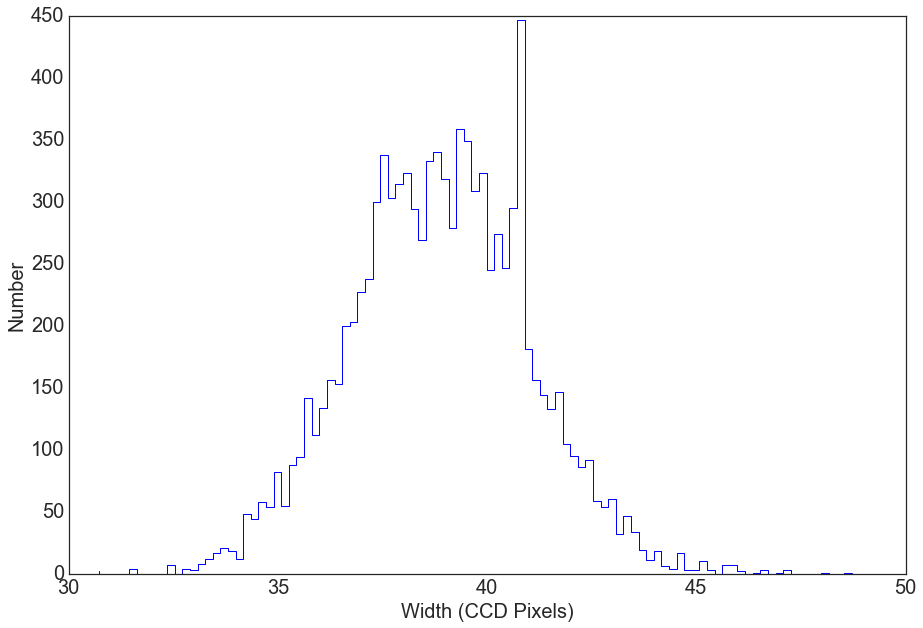

In [639]:
index=1
comp_hist_0_x,comp_hist_0_y=MakeHistogram(trial_to_examine,chain,burnin,index,numbins)
plt.xlabel('Width (CCD Pixels)')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

## Make Histogram of Baseline

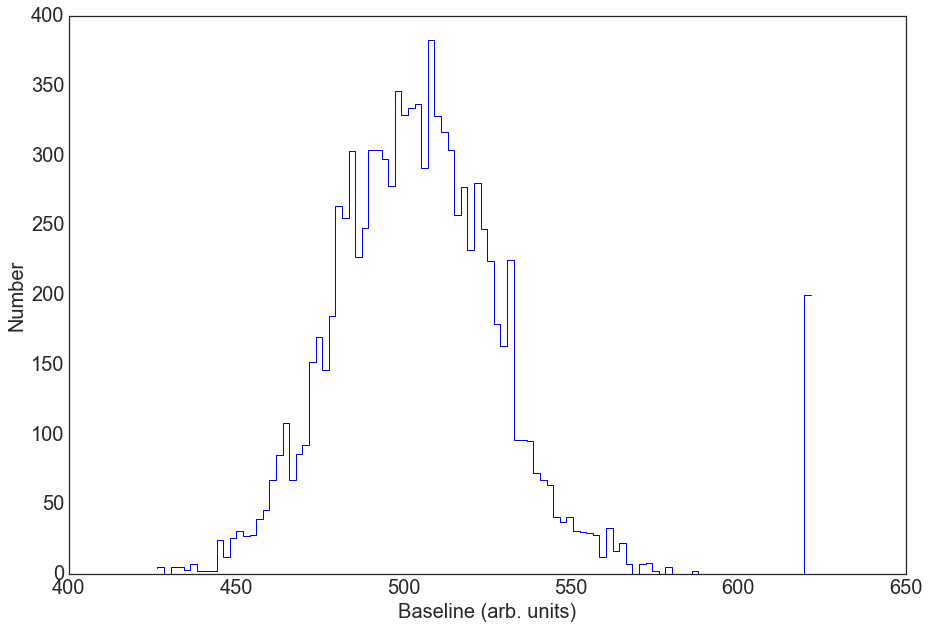

In [640]:
index=2
comp_hist_0_x,comp_hist_0_y=MakeHistogram(trial_to_examine,chain,burnin,index,numbins)
plt.xlabel('Baseline (arb. units)')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

## Make Histogram of x0

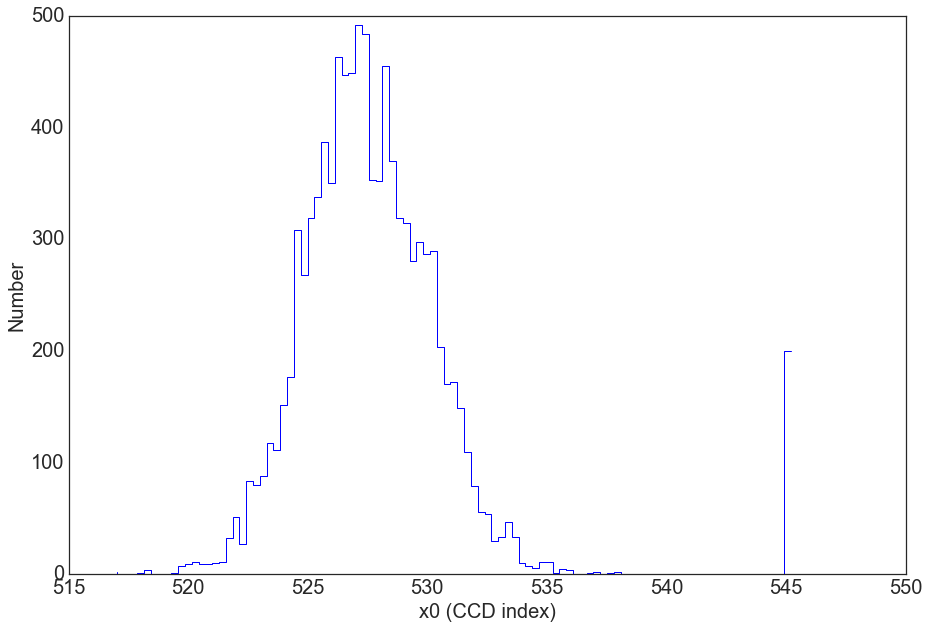

In [641]:
index=3
comp_hist_0_x,comp_hist_0_y=MakeHistogram(trial_to_examine,chain,burnin,index,numbins)
plt.xlabel('x0 (CCD index)')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

## Make Histogram of y0

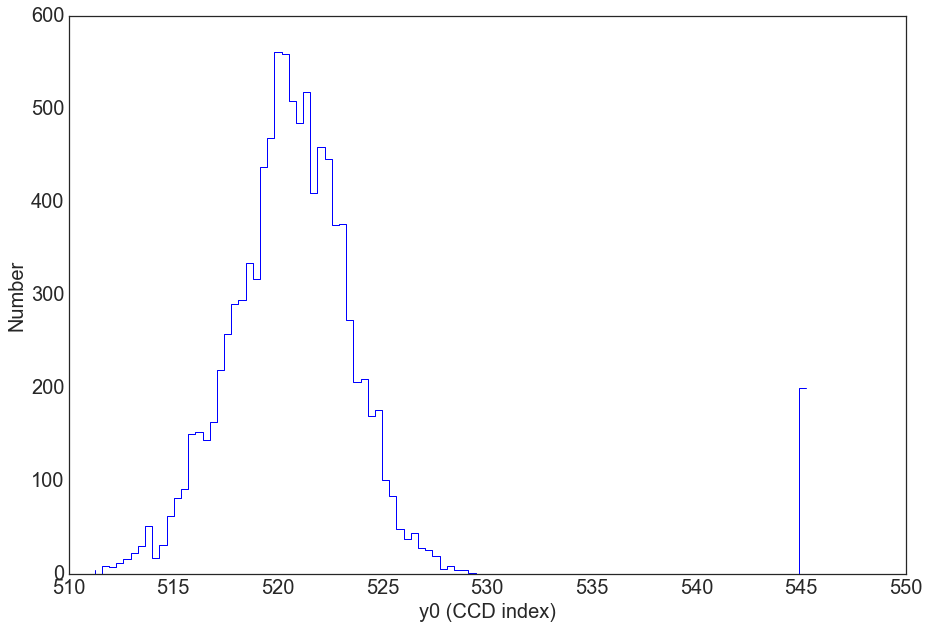

In [642]:
index=4
comp_hist_0_x,comp_hist_0_y=MakeHistogram(trial_to_examine,chain,burnin,index,numbins)
plt.xlabel('y0 (CCD index)')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

In [643]:
percent_regions=[1.0-0.9973,1.0-0.9545,1.0-0.6827,0.5,0.6827,0.9545,0.9973]

confidence_regions_params=np.zeros([7,ndim])

numsamples=len(sample)

for i in np.arange(ndim):
    temp=sample[:,i]
    
    x2=np.sort(temp)
    f2=np.array(range(numsamples))/float(numsamples)
    confidence_regions_params[0:7,i]=np.interp(percent_regions,f2,x2)

print 'The median value of Scale is ',confidence_regions_params[4,0], ' 95% interval:', [confidence_regions_params[1,0],confidence_regions_params[6,0]]
print 'The median value of Width is ',confidence_regions_params[4,1], '   95% interval:', [confidence_regions_params[1,1],confidence_regions_params[6,1]]
print 'The median value of Baseline is ',confidence_regions_params[4,2], '  95% interval:', [confidence_regions_params[1,2],confidence_regions_params[6,2]]
print 'The median value x0 is ',confidence_regions_params[4,3], '  95% interval:', [confidence_regions_params[1,3],confidence_regions_params[6,3]]
print 'The median value of y0 is ',confidence_regions_params[4,4], '  95% interval:', [confidence_regions_params[1,4],confidence_regions_params[6,4]]


NameError: name 'sample' is not defined

## Plot Redisuals

In [ ]:
trial_to_examine = 5
pylab.rcParams['figure.figsize'] = (42,10)
fitted_params=chain[trial_to_examine,:,burnin:,:]
fitted_params = np.mean(fitted_params, axis=0)
fitted_params = np.mean(fitted_params, axis=0)
print np.shape(fitted_params)
fitted_curve=Mode_1_0([fitted_params[0],fitted_params[1],fitted_params[2],fitted_params[3],fitted_params[4]],1) #+ Mode_1_1([fitted_params[5], fitted_params[6], fitted_params[2],fitted_params[3],fitted_params[4]],1)

data_new = data[trial_to_examine,:,:]
pyplot.subplot(1,3,1)
plt.title('Data')
plt.xlabel('Position (arb. units)')
plt.ylabel('Position (arb. units)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.pcolormesh(data[trial_to_examine,:,:] - fitted_params[2], cmap='GnBu_r')

plt.xlim(100,900)
plt.ylim(100,900)
plt.colorbar()
pyplot.subplot(1,3,2)
plt.title('Fit')
plt.xlabel('Position (arb. units)')
plt.ylabel('Position (arb. units)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.pcolormesh(fitted_curve - fitted_params[2], cmap='GnBu_r')
plt.colorbar()
plt.xlim(100,900)
plt.ylim(100,900)
pyplot.subplot(1,3,3)
plt.title('Residuals')
plt.xlabel('Position (arb. units)')
plt.ylabel('Position (arb. units)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.pcolormesh(data[trial_to_examine,:,:] - fitted_curve, cmap='GnBu_r')
plt.colorbar()
plt.xlim(100,900)
plt.ylim(100,900)
plt.show()

In [ ]:
print chain[10,:,burnin:,:]
print np.shape(chain[10,:,burnin:,:])
print np.mean(chain[10,:,burnin:,:],axis=0)
print np.mean(np.mean(chain[10,:,burnin:,:],axis=0),axis=0)

In [762]:
print np.sum(data[1])
print np.sum(fitted_curve1[1])
print np.shape(data[1])
print np.shape(fitted_curve[1])
print np.shape(data[1] - fitted_curve[1])

print 1 - np.sum((data[1] - fitted_curve1[1]))/np.sum(data[1])

303680892.0
285491472.636
(1024L, 1024L)
(1024L,)
(1024L, 1024L)
0.940103510484


In [ ]:
 error_function[i] = fitted_params[i,1]**-10*(np.exp((-4*fitted_params[i,3]**2 - 4.*fitted_params[i,4])/fitted_params[i,1]**2)*16.*fitted_params_err[i,0]**2.*fitted_params[i,0]**2.*fitted_params[i,1]**6.*(fitted_params[i,3]**2 + fitted_params[i,4]**2)**2) + fitted_params_err[i,2]**2*fitted_params_err[i,1]**10
    

[  75.19995329   45.16452664  257.35769983  523.0848884   521.48695618]
[ 0.33323268  0.3565378   0.07174055  0.06590902  0.09527996]
[  86.62085164   39.47510374  252.59398187  550.90804361  536.1573628 ]
[ 0.36684693  0.24335161  0.06261517  0.09649726  0.12191757]
[ 135.10683108   36.89556246  443.90534415  497.76203881  537.68634026]
[ 0.23893014  0.27050435  0.04622857  0.0460834   0.03782899]
[ 174.42592122   38.90120502  505.24005936  529.53675502  527.60417943]
[ 0.13297681  0.10747171  0.04032197  0.0099708   0.06031186]
[ 189.85022666   47.5968197   527.75778608  503.54335088  519.83493341]
[ 0.06049334  0.03841728  0.04088925  0.00461202  0.00443564]
[ 157.84494593   57.28603313  283.23445111  540.74122179  512.17437247]
[ 0.13059577  0.04492665  0.07038932  0.03285755  0.04799719]
[ 181.15131698   65.40441989  292.41382306  535.69180715  506.46378253]
[ 0.11083413  0.05128648  0.060639    0.01518485  0.020375  ]
[ 168.74616086   79.45179316  571.65872718  518.42651009  515.

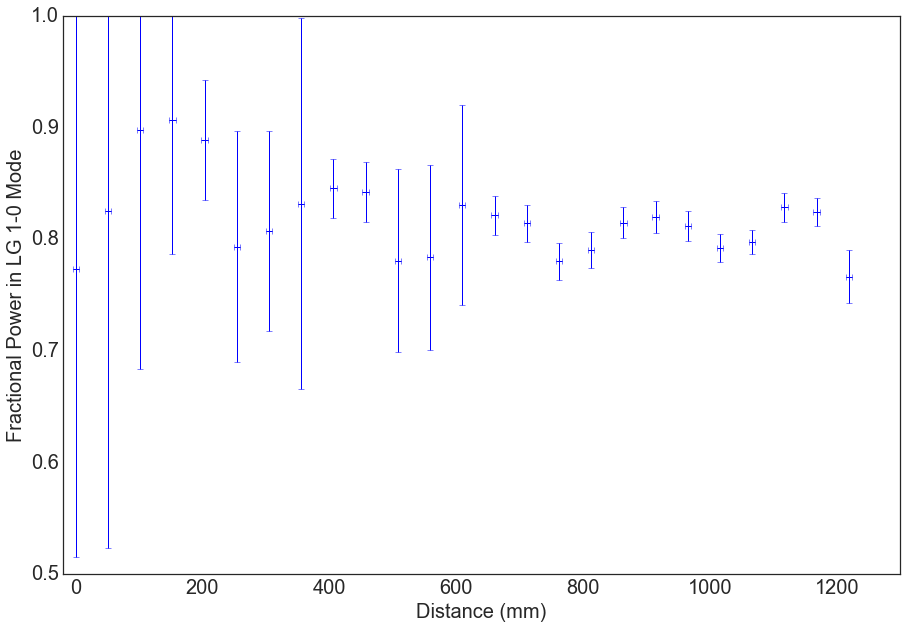

In [1019]:
fitted_params=np.zeros((NumberOfPoints,5))
fitted_params_err=np.zeros((NumberOfPoints,5))

for i in range(NumberOfPoints):

    fitted_params[i,:] = np.mean(np.mean(chain[i,:,burnin:,:],axis=0),axis=0)
    fitted_params_err[i,:] = np.mean(np.std(chain[i,:,burnin:,:],axis=0),axis=0)

fitted_curve1 = np.zeros((NumberOfPoints,1024,1024))
fitted_curve2 = np.zeros((NumberOfPoints,1024,1024))
fitted_curve_err_up = np.zeros((NumberOfPoints,1024,1024))
error_function = np.zeros((NumberOfPoints))
error = np.zeros(NumberOfPoints)

for i in range(NumberOfPoints):
    fitted_curve1[i,:,:]=Mode_1_0([fitted_params[i,0],fitted_params[i,1],fitted_params[i,2],fitted_params[i,3],fitted_params[i,4]],1) #+ Mode_1_0(fitted_params[5:], 1)
    fitted_curve2[i,:,:]=Mode_1_0([fitted_params[i,0]+10*fitted_params_err[i,0],fitted_params[i,1],fitted_params[i,2],fitted_params[i,3],fitted_params[i,4]],1)
    fitted_curve_err_down[i,:,:]=Mode_1_0([fitted_params[i,0] - fitted_params_err[i,0],fitted_params[i,1] - fitted_params_err[i,1],fitted_params[i,2] - fitted_params_err[i,2],fitted_params[i,3],fitted_params[i,4]],1)
    fitted_curve_err_up[i,:,:]=Mode_1_0([fitted_params[i,0] + fitted_params_err[i,0],fitted_params[i,1] + fitted_params_err[i,1],fitted_params[i,2] + fitted_params_err[i,2],fitted_params[i,3],fitted_params[i,4]],1)
    error[i] = np.asarray(np.mean(fitted_params_err[i,:1])/np.mean(fitted_params[i,:1]))

    print fitted_params[i,:]
    print fitted_params_err[i,:]/fitted_params[i,:]


residuals1 = data - fitted_curve1
residuals_errors1 = np.sqrt(np.abs(residuals1))



power = np.zeros(NumberOfPoints)
power_err = np.zeros(NumberOfPoints)
background_ratio = np.zeros(NumberOfPoints)
residual_power = np.zeros(NumberOfPoints)
power_sd_down = np.zeros(NumberOfPoints)
power_sd_up = np.zeros(NumberOfPoints)


for i in range(NumberOfPoints):
    background_ratio[i] = 1 -np.sum(data[i] - fitted_params[i,2])/np.sum(data[i])
    power_err[i] = 1 - np.sum(np.abs((data[i] - fitted_curve2[i])))/np.sum(data[i])
    power[i] = 1 - np.sum(np.abs((data[i] - fitted_curve1[i])))/np.sum(data[i])



print power
pylab.rcParams['figure.figsize'] = (15,10)
plt.errorbar(np.arange(25)*50.8, power, yerr = power*error, xerr = 5, fmt='+')

plt.xlim((-20,1300))
plt.ylim((0.5,1.0))
plt.ylabel('Fractional Power in LG 1-0 Mode')
plt.xlabel('Distance (mm)')

In [926]:
print fitted_params

[ 306.57668029  312.03045237  594.19019537  547.17289151  550.18407636]


In [818]:
print error_function[5]
print np.sum(data[5])

11775137921.4
472060606.0


In [ ]:
import scipy.stats
print np.corrcoef(data[trial_to_examine], fitted_curve)
print np.mean(np.corrcoef(data[trial_to_examine], fitted_curve))

In [1021]:
def Main2(data_to_fit, errors_to_fit, guesses, numsims=500, burnin=250, nwalkers=100):

    ndim = 5
    
    nwalkers = 50
    
    scale_i1 = guesses[0]+100.0*np.random.randn(nwalkers)
    width_i1 = guesses[1]+5.0*np.random.randn(nwalkers)
    baseline_i1 = guesses[2]+30.0*np.random.randn(nwalkers)
    x0_i1 = guesses[3]+10.0*np.random.randn(nwalkers)
    y0_i1 = guesses[4]+10.0*np.random.randn(nwalkers)
    

    pos = [scale_i1]+[width_i1]+[baseline_i1]+[x0_i1]+[y0_i1]
    posNew=(np.array(pos)).T

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior2, args=[data_to_fit, errors_to_fit])
    %time sampler.run_mcmc(posNew, numsims) # %time is used to time this line of the function. It will print the CPU time in the output
    
    chain=sampler.chain
    lnprob=sampler.lnprobability
    acceptance=sampler.acceptance_fraction
    
    
    percent_regions=[1.0-0.9973,1.0-0.9545,1.0-0.6827,0.5,0.6827,0.9545,0.9973]

    confidence_regions_params=np.zeros([7,ndim])

    acceptances = [np.percentile(acceptance, 5), np.percentile(acceptance, 50), np.percentile(acceptance, 95)]
    scale = [np.percentile(chain[:,burnin:numsims,0], 5), np.percentile(chain[:,burnin:numsims,0], 50), np.percentile(chain[:,burnin:numsims,0], 95)]
    width =  [np.percentile(chain[:,burnin:numsims,1], 5), np.percentile(chain[:,burnin:numsims,1], 50), np.percentile(chain[:,burnin:numsims,1], 95)]
    background =  [np.percentile(chain[:,burnin:numsims,2], 5), np.percentile(chain[:,burnin:numsims,2], 50), np.percentile(chain[:,burnin:numsims,2], 95)]
    x0 =  [np.percentile(chain[:,burnin:numsims,3], 5), np.percentile(chain[:,burnin:numsims,3], 50), np.percentile(chain[:,burnin:numsims,3], 95)]
    y0 =  [np.percentile(chain[:,burnin:numsims,4], 5), np.percentile(chain[:,burnin:numsims,4], 50), np.percentile(chain[:,burnin:numsims,4], 95)]
    logPDF = [np.percentile(lnprob[:, burnin:numsims], 5), np.percentile(lnprob[:, burnin:numsims], 50), np.percentile(lnprob[:, burnin:numsims], 95)]
    
    
    return acceptances, scale, width, background, x0, y0, logPDF, chain, lnprob, acceptance

In [ ]:
ndim = 5
numsims = 300
nwalkers=50
burnin=100
binfactor=16
X, Y = np.meshgrid(np.arange(1,1024 +1 ,binfactor), np.arange(1,1024 + 1,binfactor))

guesses = [300,55,70,550,550] #guesses ONLY for first run. Everything else done recursively.


scale_i1 = guesses[0]+75.0*np.random.randn(nwalkers)
width_i1 = guesses[1]+5.0*np.random.randn(nwalkers)
baseline_i1 = guesses[2]+50.0*np.random.randn(nwalkers)
x0_i1 = guesses[3]+20.0*np.random.randn(nwalkers)
y0_i1 = guesses[4]+20.0*np.random.randn(nwalkers)


acceptances2 = np.zeros((NumberOfPoints,3))
scales2 = np.zeros((NumberOfPoints,3))
widths2 = np.zeros((NumberOfPoints,3))
backgrounds2 = np.zeros((NumberOfPoints,3))
x0s2 = np.zeros((NumberOfPoints,3))
y0s2 = np.zeros((NumberOfPoints,3))
logPDFs2 = np.zeros((NumberOfPoints,3))
chain2 = np.zeros((NumberOfPoints, nwalkers, numsims, ndim))
lnprob2 = np.zeros((NumberOfPoints, nwalkers, numsims))
acceptance2 = np.zeros((NumberOfPoints, nwalkers))


for i in range(NumberOfPoints):
    
    residuals_new = rebin(residuals1[i,:,:], (1024/binfactor,1024/binfactor))
    residuals_err_new = rebin(residuals_errors1[i,:,:], (1024/binfactor,1024/binfactor))
    
    acceptances2[i,:], scales2[i,:], widths2[i,:], backgrounds2[i,:], x0s2[i,:], y0s2[i,:], logPDFs2[i,:], chain2[i,:,:,:], lnprob2[i,:,:], acceptance2[i,:] = Main2(residuals_new, residuals_err_new, guesses, numsims, burnin, nwalkers)
    
    guesses[1] = guesses[1] + 6
    

Wall time: 7.57 s
Wall time: 6.9 s
Wall time: 6.31 s
Wall time: 6.59 s
Wall time: 5.35 s
Wall time: 11.4 s
Wall time: 10.6 s


In [ ]:
plt.plot(acceptance2[:])
plt.xlabel('Walker no.')
plt.ylabel('Acceptance Fraction')

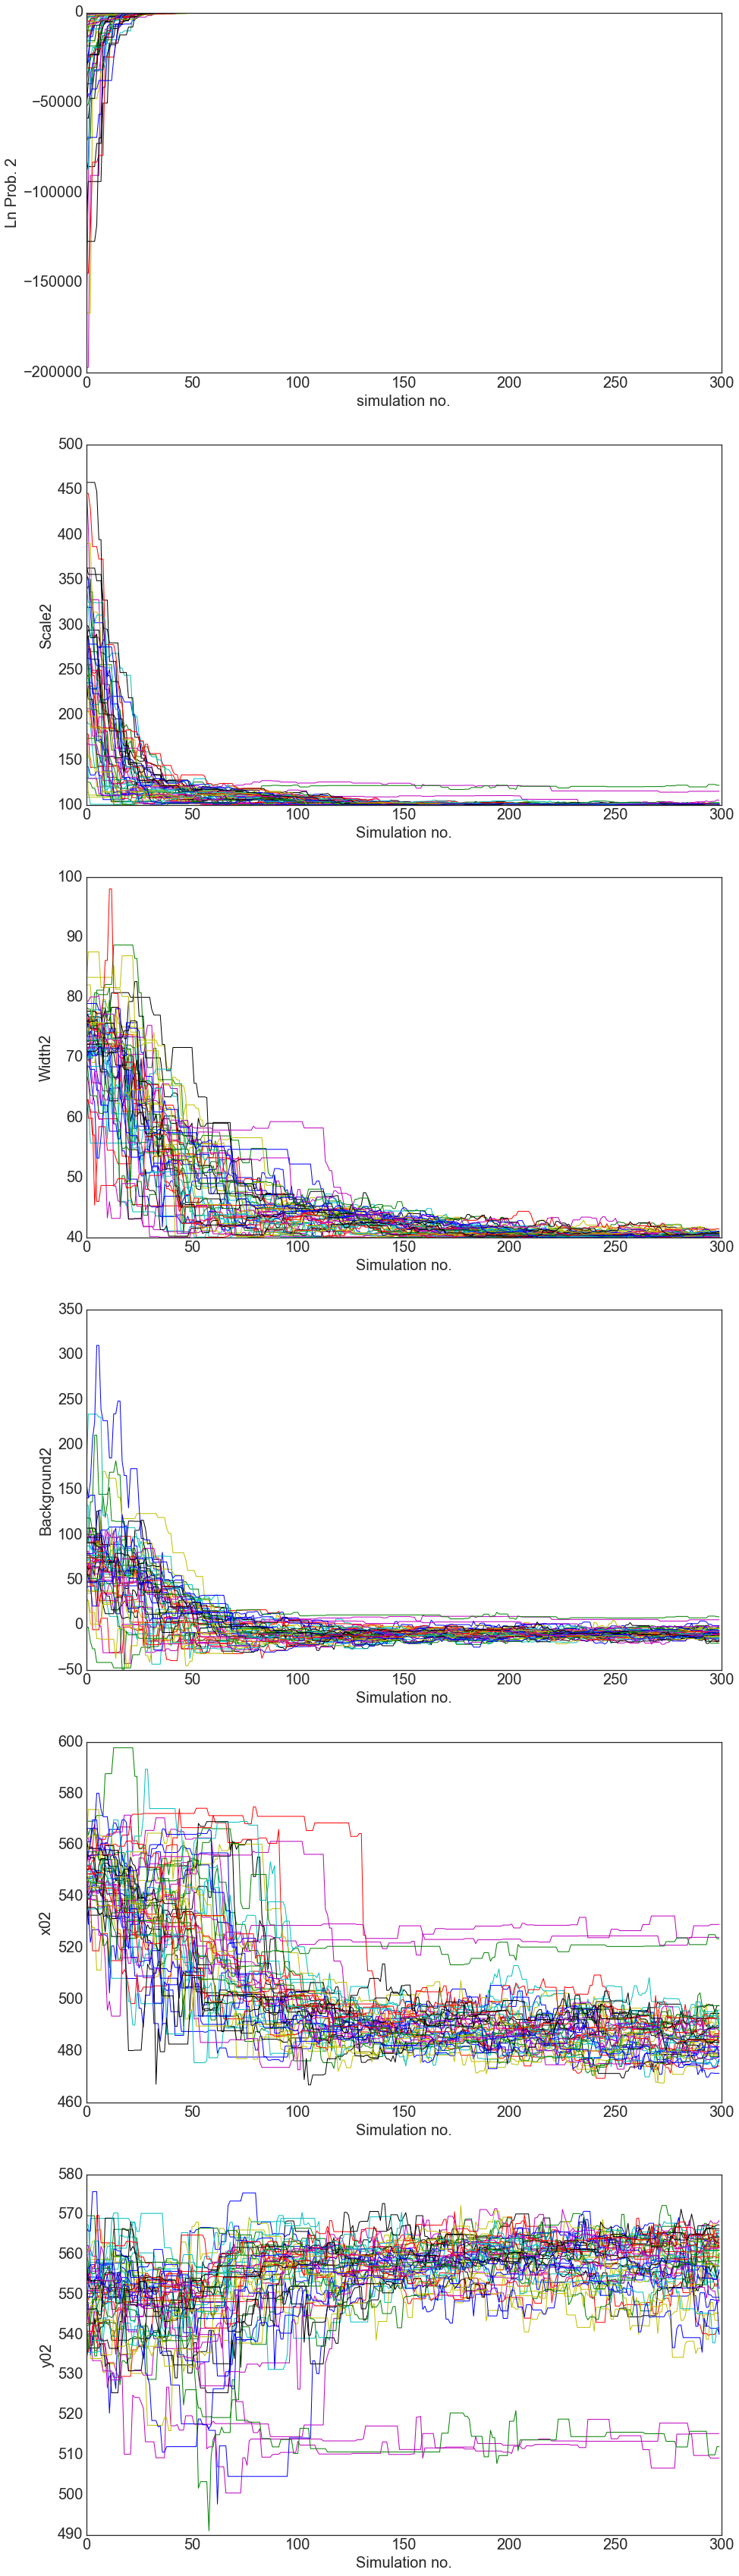

In [1028]:
trial_to_examine = 20
burnin_plot = 0

index = np.arange(numsims)
from matplotlib import pyplot
trial_to_examine = 3
pylab.rcParams['figure.figsize'] = (15,80)
for i in range(nwalkers):
    pyplot.subplot(8,1,1)
    plt.plot(index[burnin_plot:], lnprob2[trial_to_examine,i, burnin_plot:numsims])
    plt.xlabel('simulation no.')
    plt.ylabel('Ln Prob. 2')
    
    pyplot.subplot(8,1,2)
    plt.plot(index[burnin_plot:], chain2[trial_to_examine,i,burnin_plot:numsims,0])
    plt.xlabel('Simulation no.')
    plt.ylabel('Scale2')
    
    pyplot.subplot(8,1,3)
    plt.plot(index[burnin_plot:], chain2[trial_to_examine,i,burnin_plot:numsims,1])
    plt.xlabel('Simulation no.')
    plt.ylabel('Width2')
    
    pyplot.subplot(8,1,4)
    plt.plot(index[burnin_plot:], chain2[trial_to_examine,i,burnin_plot:numsims,2])
    plt.xlabel('Simulation no.')
    plt.ylabel('Background2')

    pyplot.subplot(8,1,5)
    plt.plot(index[burnin_plot:], chain2[trial_to_examine,i,burnin_plot:numsims,3])
    plt.xlabel('Simulation no.')
    plt.ylabel('x02')
    
    pyplot.subplot(8,1,6)
    plt.plot(index[burnin_plot:], chain2[trial_to_examine,i,burnin_plot:numsims,4])
    plt.xlabel('Simulation no.')
    plt.ylabel('y02')
    

    
plt.show()

In [ ]:
trial_to_examine = 5
pylab.rcParams['figure.figsize'] = (42,10)
fitted_params2=chain[trial_to_examine,:,burnin:,:]
fitted_params2 = np.mean(fitted_params2, axis=0)
fitted_params2 = np.mean(fitted_params2, axis=0)
print np.shape(fitted_params2)
fitted_curve2=Mode_1_1([fitted_params2[0],fitted_params2[1],fitted_params2[2],fitted_params2[3],fitted_params2[4]],1) #+ Mode_1_1([fitted_params[5], fitted_params[6], fitted_params[2],fitted_params[3],fitted_params[4]],1)

data_new = data[trial_to_examine,:,:]
pyplot.subplot(1,3,1)
plt.title('Data')
plt.xlabel('Position (arb. units)')
plt.ylabel('Position (arb. units)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.pcolormesh(data[trial_to_examine,:,:] - fitted_curve, cmap='GnBu_r')

plt.xlim(100,900)
plt.ylim(100,900)
plt.colorbar()
pyplot.subplot(1,3,2)
plt.title('Fit')
plt.xlabel('Position (arb. units)')
plt.ylabel('Position (arb. units)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.pcolormesh(fitted_curve2 - fitted_params2[2], cmap='GnBu_r')
plt.colorbar()
plt.xlim(100,900)
plt.ylim(100,900)
pyplot.subplot(1,3,3)
plt.title('Residuals')
plt.xlabel('Position (arb. units)')
plt.ylabel('Position (arb. units)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.pcolormesh(data[trial_to_examine,:,:] - fitted_curve - fitted_curve2 - fitted_params2[2], cmap='GnBu_r')
plt.colorbar()
plt.xlim(100,900)
plt.ylim(100,900)
plt.show()